**AlexNet**

1. Installing Dependencies

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import time

The above snippet consists of the dependencies that you have to load into your system. In case of the dataset, we used the CIFAR10 dataset. We can load it directly using Keras. Now we are going to set training and testing dataset. But before that preprocessing is done to assure size of images as 227 x 227 for AlexNet. Look at the python code below:

In [4]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship', 'truck']

validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

Training Dataset: This is the group of our dataset used to train the neural network directly. Training data refers to the dataset partition exposed to the neural network during training.

Validation Dataset: This group of the dataset is utilized during training to assess the performance of the network at various iterations.

Test Dataset: This partition of the dataset evaluates the performance of our network after the completion of the training phase.

Preprocessing

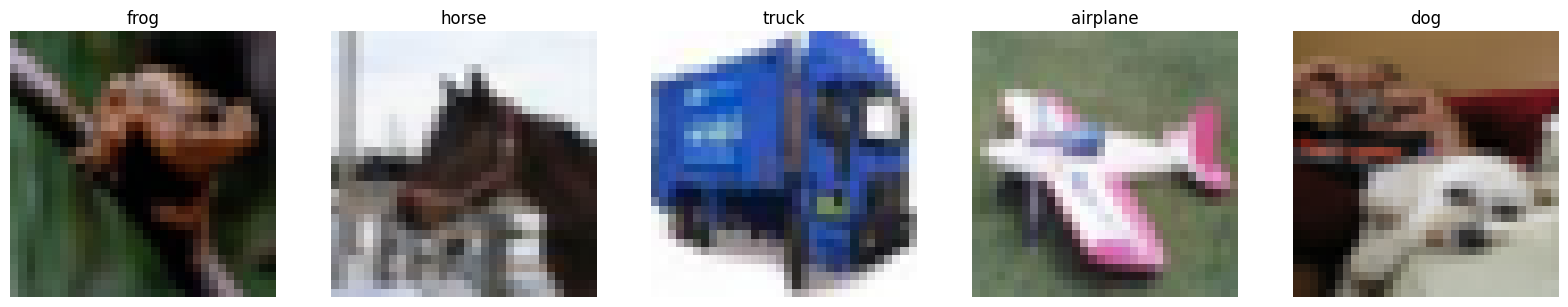

In [5]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [6]:
#Preprocessing

def process_images(image, label):

   # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
     # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

2. Loading Data

The above snippet gives you details about loading the dataset and preprocessing the data. In the next snippet, We will see the pipeline that is created for the implementation. Let’s get the size of each of the dataset partition we created; the sizes of the dataset partitions are required to ensure that the dataset is thoroughly shuffled before passed through the network.

In [7]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


3. For our basic input/data pipeline, we will conduct three primary operations:

Preprocessing the data within the dataset
Shuffle the dataset
Batch data within the dataset

In [8]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

4. Model Implementation

In [9]:
#The code snippet represents the Keras implementation of the AlexNet CNN architecture.
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

5. TensorBoard

TensorBoard is a tool that provides a suite of visualization and monitoring mechanisms. For the work in this tutorial, we’ll be utilizing TensorBoard to monitor the progress of the training of the network.

More specifically, we’ll be monitoring the following metrics: training loss, training accuracy, validation loss, validation accuracy.

In [10]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

6. Training and Results

The compilation processes involve specifying the following items:

Loss function: A method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the predictions and the actual values.

Optimization Algorithm: An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function. To reduce the loss, it is paramount the values of the weights within the network are selected appropriately.

Learning Rate: An integral component of a neural network implementation detail as it’s a factor value that determines the level of updates that are made to the values of the weights of the network. Learning rate is a type of hyperparameter.

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()
We can also provide a summary of the network to have more insight into the layer composition of the network by running the model.summary()function.

Train the Network

In [ ]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50


Model Evaluaion

In [1]:
model.evaluate(test_ds)

NameError: ignored